# Mixture model on a polynomial surface: manifold plots

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
import torch
import logging
from matplotlib import pyplot as plt, cm
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("../../")
from experiments.datasets import PolynomialSurfaceSimulator
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow
import plot_settings as ps

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [ ]:
ps.setup()

## Set up simulator

In [3]:
sim = PowerManifoldSimulator(
    draw_constants=False,
    filename="../data/samples/power/manifold.npz"
)


## Load flows

In [4]:
def load_model(filename):
    outer_transform = create_vector_transform(
        3,
        5,
        linear_transform_type="permutation",
        base_transform_type="rq-coupling",
        context_features=None,
        dropout_probability=0.,
        tail_bound=6.,
        num_bins=10,
    )
    inner_transform = create_vector_transform(
        2,
        5,
        linear_transform_type="permutation",
        base_transform_type="rq-coupling",
        context_features=sim.parameter_dim(),
        dropout_probability=0.,
        tail_bound=6.,
        num_bins=10,
    )

    model = ManifoldFlow(
        data_dim=3,
        latent_dim=2,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
    )
    
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [5]:
mlfa = load_model("mf_2_power_alternate_march_run2")
pie = load_model("pie_2_power_march_run1")
mlfot = load_model("gamf_2_power_march_run2")


14:28 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 3 to vector with dimension 2
14:28 manifold_flow.flows.base       DEBUG   Flow has 0.4 M parameters (0.4 M trainable) with an estimated size of 1.8 MB
14:28 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 3 to vector with dimension 2
14:28 manifold_flow.flows.base       DEBUG   Flow has 0.4 M parameters (0.4 M trainable) with an estimated size of 1.8 MB
14:28 manifold_flow.transforms.proje DEBUG   Set up projection from vector with dimension 3 to vector with dimension 2
14:28 manifold_flow.flows.base       DEBUG   Flow has 0.4 M parameters (0.4 M trainable) with an estimated size of 1.8 MB


## Get data

In [6]:
def make_grid(boundary, res):
    grid_each = np.linspace(-boundary, boundary, res)
    x, y = np.meshgrid(grid_each, grid_each)
    xy = np.vstack((x.flatten(), y.flatten())).T
    return xy

In [7]:
thetas = [-1., 0., 1.]
boundary = 4.
res = 75

z_grid = make_grid(boundary, res)
f_grid = sim._fz(z_grid).flatten()
x_grid = sim._transform_z_to_x(z_grid)

In [8]:
true_logp_grid = np.array(
    [sim._log_density_z(z_grid, parameters=theta*np.ones((res**2,1))).flatten() for theta in thetas]
)


In [9]:
def eval_model(model, algo, batchsize=400, thetas=thetas):
    print("Let's go!")
    n_batches = (res**2 - 1) // batchsize + 1

    model_x_grid = []
    model_logp_grid = []

    for i_theta, theta in enumerate(thetas):
        print("Theta {} / {}".format(i_theta + 1, len(thetas)))
        for i in range(n_batches):
            print("Batch {} / {}".format(i + 1, n_batches))
            x_batch = x_grid[i*batchsize:(i+1)*batchsize]
            n_batch = len(x_batch)

            theta_ = torch.tensor(theta*np.ones((n_batch,1)), dtype=torch.float)
            x_ = torch.tensor(x_batch, dtype=torch.float)

            x_reco_, logp_, u_ = model(x_, mode=algo, context=theta_)
            if algo=="pie":
                _, logp_, _ = model(x_reco_, mode=algo, context=theta_)

            model_x_grid.append(x_reco_.detach().numpy().flatten())
            model_logp_grid.append(logp_.detach().numpy().flatten())

    model_logp_grid = np.hstack(model_logp_grid).reshape((len(thetas), -1))
    model_x_grid = np.hstack(model_x_grid).reshape((len(thetas), -1, 3))

    return model_x_grid, model_logp_grid


In [10]:
mlfa_x_grid, mlfa_logp_grid = eval_model(mlfa, "mf")
mlfot_x_grid, mlfot_logp_grid = eval_model(mlfot, "mf", thetas=[0.])

Let's go!
Theta 1 / 3
Batch 1 / 15
Batch 2 / 15
Batch 3 / 15
Batch 4 / 15
Batch 5 / 15
Batch 6 / 15
Batch 7 / 15
Batch 8 / 15
Batch 9 / 15
Batch 10 / 15
Batch 11 / 15
Batch 12 / 15
Batch 13 / 15
Batch 14 / 15
Batch 15 / 15
Theta 2 / 3
Batch 1 / 15
Batch 2 / 15
Batch 3 / 15
Batch 4 / 15
Batch 5 / 15
Batch 6 / 15
Batch 7 / 15
Batch 8 / 15
Batch 9 / 15
Batch 10 / 15
Batch 11 / 15
Batch 12 / 15
Batch 13 / 15
Batch 14 / 15
Batch 15 / 15
Theta 3 / 3
Batch 1 / 15
Batch 2 / 15
Batch 3 / 15
Batch 4 / 15
Batch 5 / 15
Batch 6 / 15
Batch 7 / 15
Batch 8 / 15
Batch 9 / 15
Batch 10 / 15
Batch 11 / 15
Batch 12 / 15
Batch 13 / 15
Batch 14 / 15
Batch 15 / 15
Let's go!
Theta 1 / 1
Batch 1 / 15
Batch 2 / 15
Batch 3 / 15
Batch 4 / 15
Batch 5 / 15
Batch 6 / 15
Batch 7 / 15
Batch 8 / 15
Batch 9 / 15
Batch 10 / 15
Batch 11 / 15
Batch 12 / 15
Batch 13 / 15
Batch 14 / 15
Batch 15 / 15


In [11]:
pie_x_grid, pie_logp_grid = eval_model(pie, "pie", thetas=[0.])

Let's go!
Theta 1 / 1
Batch 1 / 15
Batch 2 / 15
Batch 3 / 15
Batch 4 / 15
Batch 5 / 15
Batch 6 / 15
Batch 7 / 15
Batch 8 / 15
Batch 9 / 15
Batch 10 / 15
Batch 11 / 15
Batch 12 / 15
Batch 13 / 15
Batch 14 / 15
Batch 15 / 15


In [12]:
_,mlfa_pielogp_grid = eval_model(mlfa, "pie", thetas=[0.])
_, pie_mlflogp_grid = eval_model(pie, "mf", thetas=[0.])

Let's go!
Theta 1 / 1
Batch 1 / 15
Batch 2 / 15
Batch 3 / 15
Batch 4 / 15
Batch 5 / 15
Batch 6 / 15
Batch 7 / 15
Batch 8 / 15
Batch 9 / 15
Batch 10 / 15
Batch 11 / 15
Batch 12 / 15
Batch 13 / 15
Batch 14 / 15
Batch 15 / 15
Let's go!
Theta 1 / 1
Batch 1 / 15
Batch 2 / 15
Batch 3 / 15
Batch 4 / 15
Batch 5 / 15
Batch 6 / 15
Batch 7 / 15
Batch 8 / 15
Batch 9 / 15
Batch 10 / 15
Batch 11 / 15
Batch 12 / 15
Batch 13 / 15
Batch 14 / 15
Batch 15 / 15


## Plot

In [29]:
xs = [
    x_grid, pie_x_grid[0], mlfa_x_grid[1], mlfot_x_grid[0],
    x_grid, mlfa_x_grid[0], x_grid, mlfa_x_grid[2]
]
logps = [
    true_logp_grid[1], pie_logp_grid[0], mlfa_logp_grid[1], mlfot_logp_grid[0],
    true_logp_grid[0], mlfa_logp_grid[0], true_logp_grid[2], mlfa_logp_grid[2]
]
labels = [
    r"Ground truth, $\theta = 0$",
    r"PIE, $\theta = 0$",
    r"MFMF–M/D, $\theta = 0$",
    r"MFMF–OT, $\theta = 0$",
    #
    r"Ground truth, $\theta = -1$",
    r"MFMF–M/D, $\theta = -1$",
    r"Ground truth, $\theta = 1$",
    r"MFMF–M/D, $\theta = 1$"
]


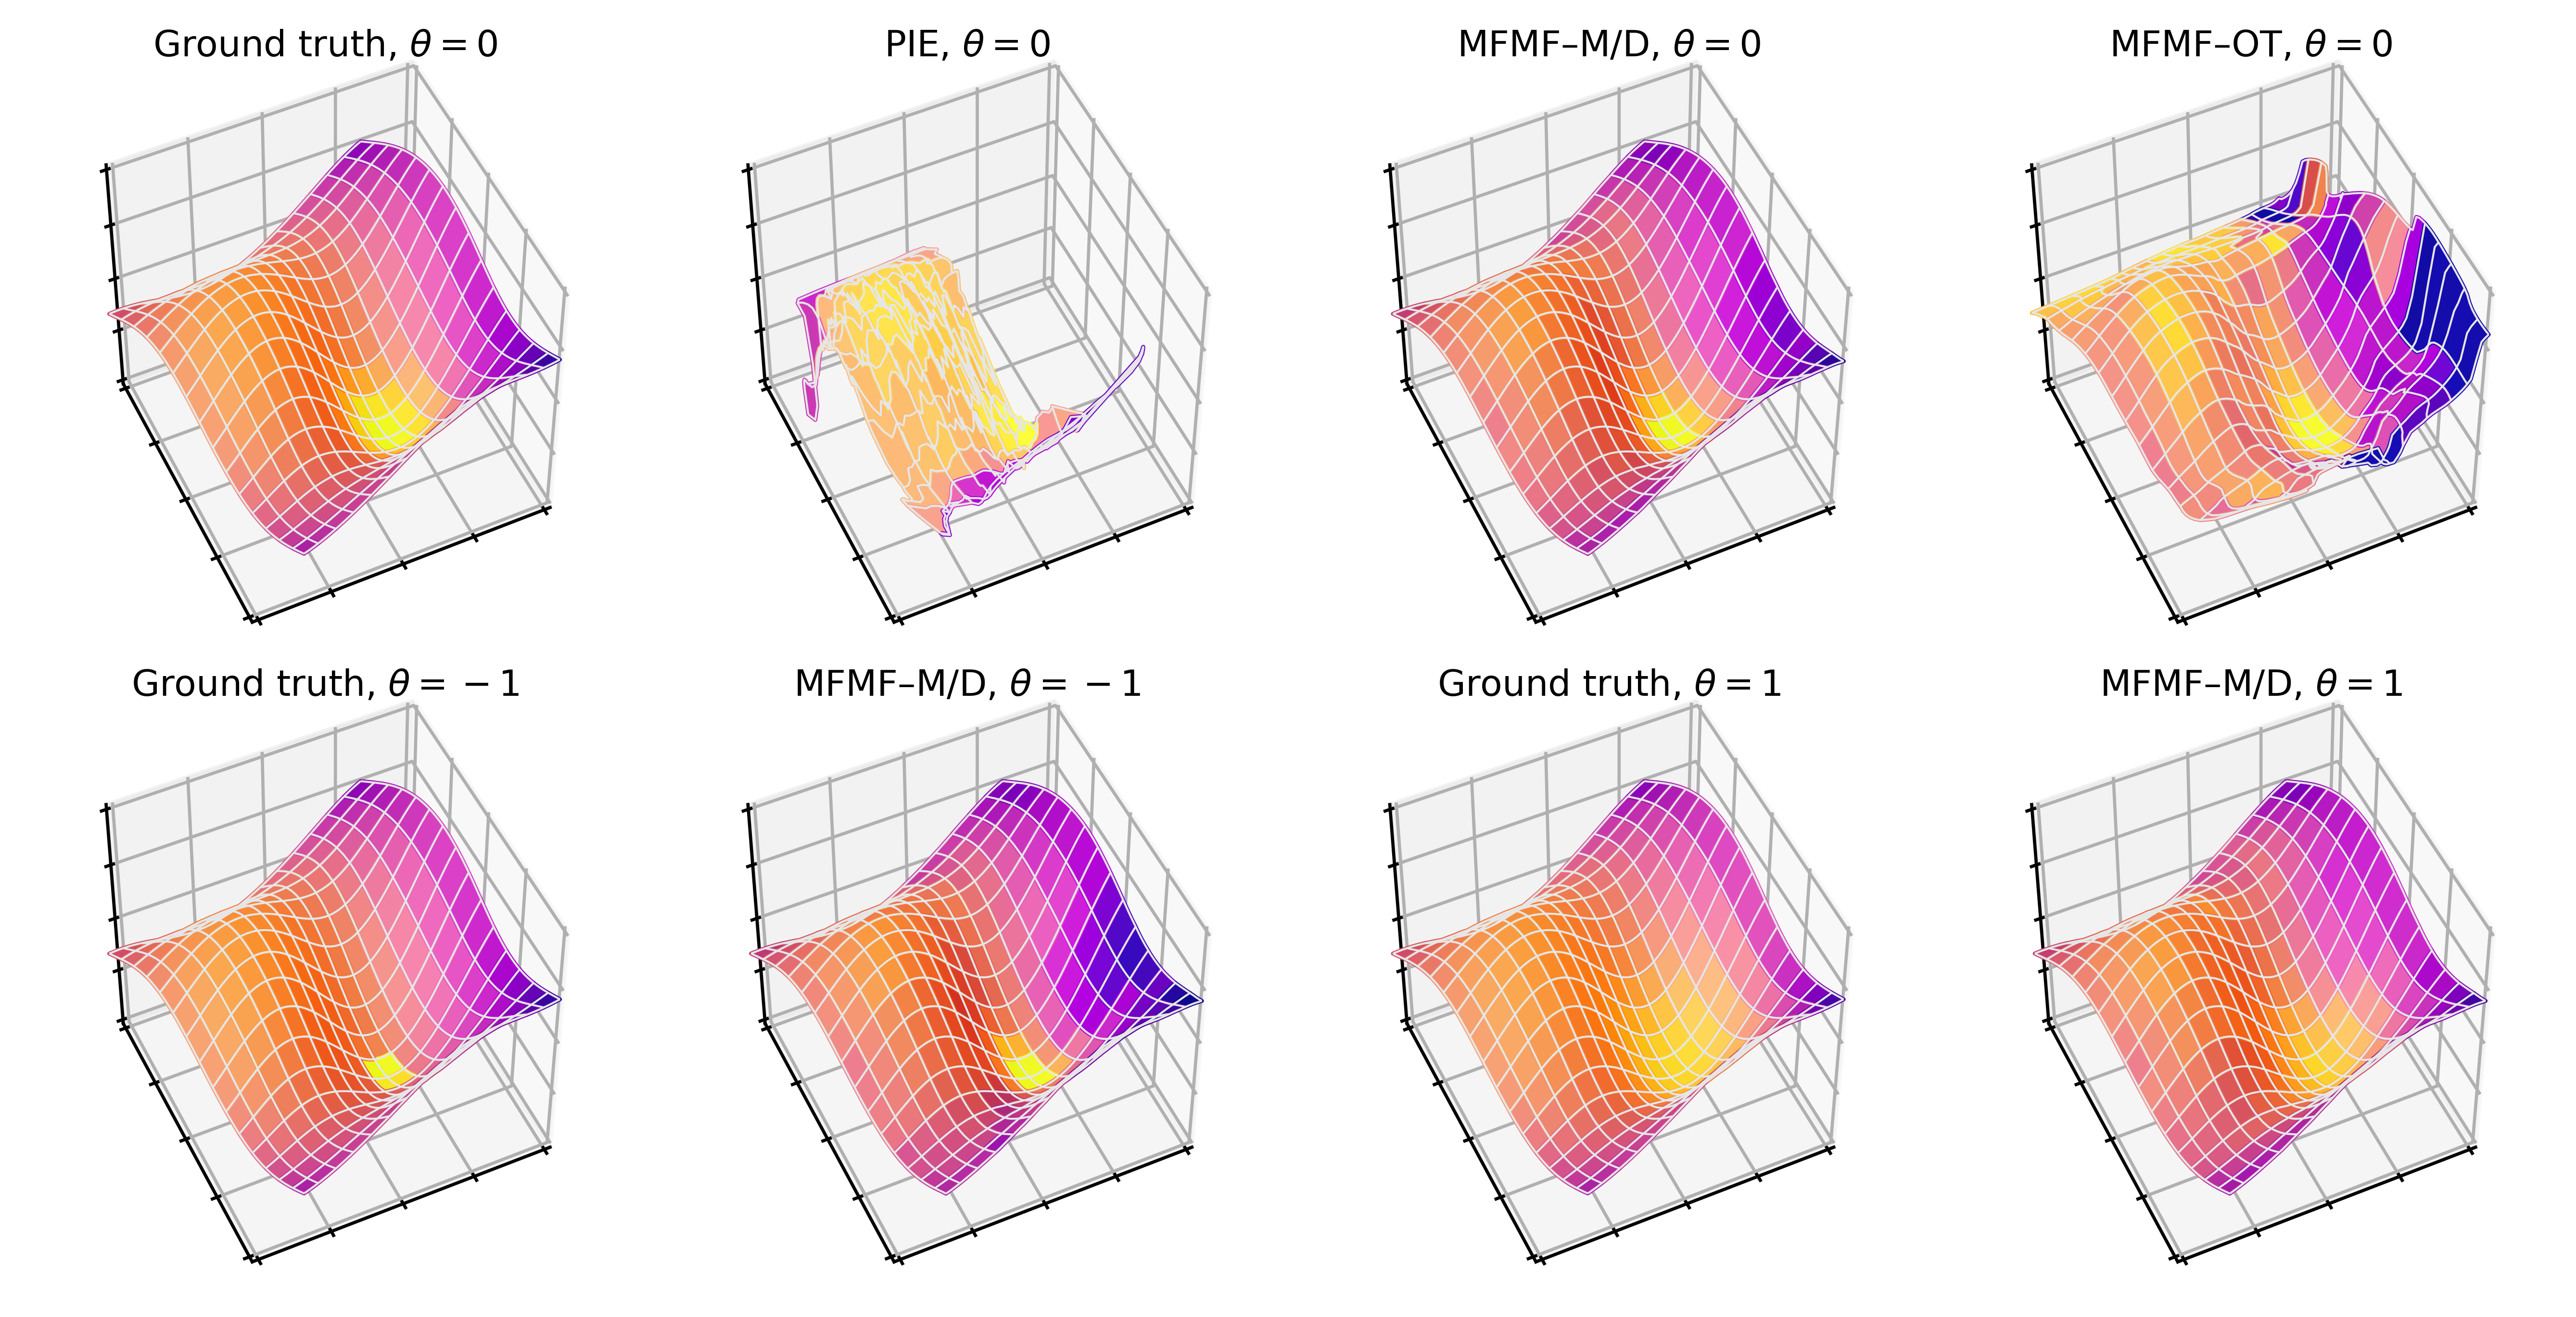

In [31]:
cmin, cmax = -10., -2.

def cmap(vals):
    return ps.CMAP(np.clip((vals - cmin) / (cmax - cmin), 0., 1.))


fig, gs = ps.grid_width(4, 2, sep=0.03, lb_space=False)

for i, (x, logp, label) in enumerate(zip(xs, logps, labels)):
    ax = plt.subplot(gs[i], projection="3d")
    
    if i == 1:
        cmin, cmax = -8., 5.
    else:
        cmin, cmax = -10., -2.
        
    rgb = cmap(logp).reshape((res, res, 4))
    ls = LightSource(azdeg=90, altdeg=75)
    rgb_shaded = ls.shade_rgb(
        rgb[:,:,:3], elevation=x[:,2].reshape((res, res)), fraction=1.0, vert_exag=0.5, blend_mode="soft"
    )
    
    if i == 1:
        cut0 = 5
        cut1 = 8
        cut2 = 30
        cut3 = 4
        ax.plot_surface(
            x[:,0].reshape((res, res))[cut0:-cut1,cut2:-cut3],
            x[:,1].reshape((res, res))[cut0:-cut1,cut2:-cut3],
            x[:,2].reshape((res, res))[cut0:-cut1,cut2:-cut3],
            facecolors=rgb_shaded[cut0:-cut1,cut2:-cut3],
            rstride=5, cstride=5,
            # alpha=0.5,
            shade=False
        )
        ax.plot_wireframe(
            x[:,0].reshape((res, res))[cut0:-cut1,cut2:-cut3],
            x[:,1].reshape((res, res))[cut0:-cut1,cut2:-cut3],
            x[:,2].reshape((res, res))[cut0:-cut1,cut2:-cut3],
            rstride=5, cstride=5,
            linewidth=0.5,
            colors="0.9"
        )
    else:
        ax.plot_surface(
            x[:,0].reshape((res, res)),
            x[:,1].reshape((res, res)),
            x[:,2].reshape((res, res)),
            facecolors=rgb_shaded,
            rstride=5, cstride=5,
            shade=False
        )
        ax.plot_wireframe(
            x[:,0].reshape((res, res)),
            x[:,1].reshape((res, res)),
            x[:,2].reshape((res, res)),
            rstride=5, cstride=5,
            linewidth=0.5,
            colors="0.9"
        )

    ax.set_xlim3d(-boundary, boundary)
    ax.set_ylim3d(-boundary, boundary)
    ax.set_zlim3d(-boundary, boundary)

    ax.set_title(label, fontsize=9, pad=10)
    ax.set_xticklabels([""]*3)
    ax.set_yticklabels([""]*3)
    ax.set_zticklabels([""]*3)
    
    ax.view_init(50, 65)

plt.savefig("../figures/mixture_manifold.pdf")


## Compare slice and correct density

In [22]:
xs = [
    mlfa_x_grid[1], mlfa_x_grid[1], mlfa_x_grid[1]
]
logps = [
    mlfa_pielogp_grid[0], mlfa_logp_grid[1], mlfa_pielogp_grid[0] - mlfa_logp_grid[1]
]
labels = [
    r"PIE density",
    r"MFMF density",
    r"PIE density / MFMF density",
]



In [23]:
m = np.mean(mlfa_pielogp_grid[0] - mlfa_logp_grid[1])
s = np.std(mlfa_pielogp_grid[0] - mlfa_logp_grid[1])

np.exp(m - 2*s), np.exp(m + 2*s)

(56.77167183677131, 1491.3843620769005)

In [24]:
m = np.mean(mlfa_logp_grid[0])
s = np.std(mlfa_logp_grid[0])

np.exp(m - 2*s), np.exp(m + 2*s)

(0.00012210116343559655, 0.07208969375335271)

In [25]:
m = np.mean(mlfa_pielogp_grid[0])
s = np.std(mlfa_pielogp_grid[0])

np.exp(m - 2*s), np.exp(m + 2*s)

(0.060500687807731365, 21.66094510745133)

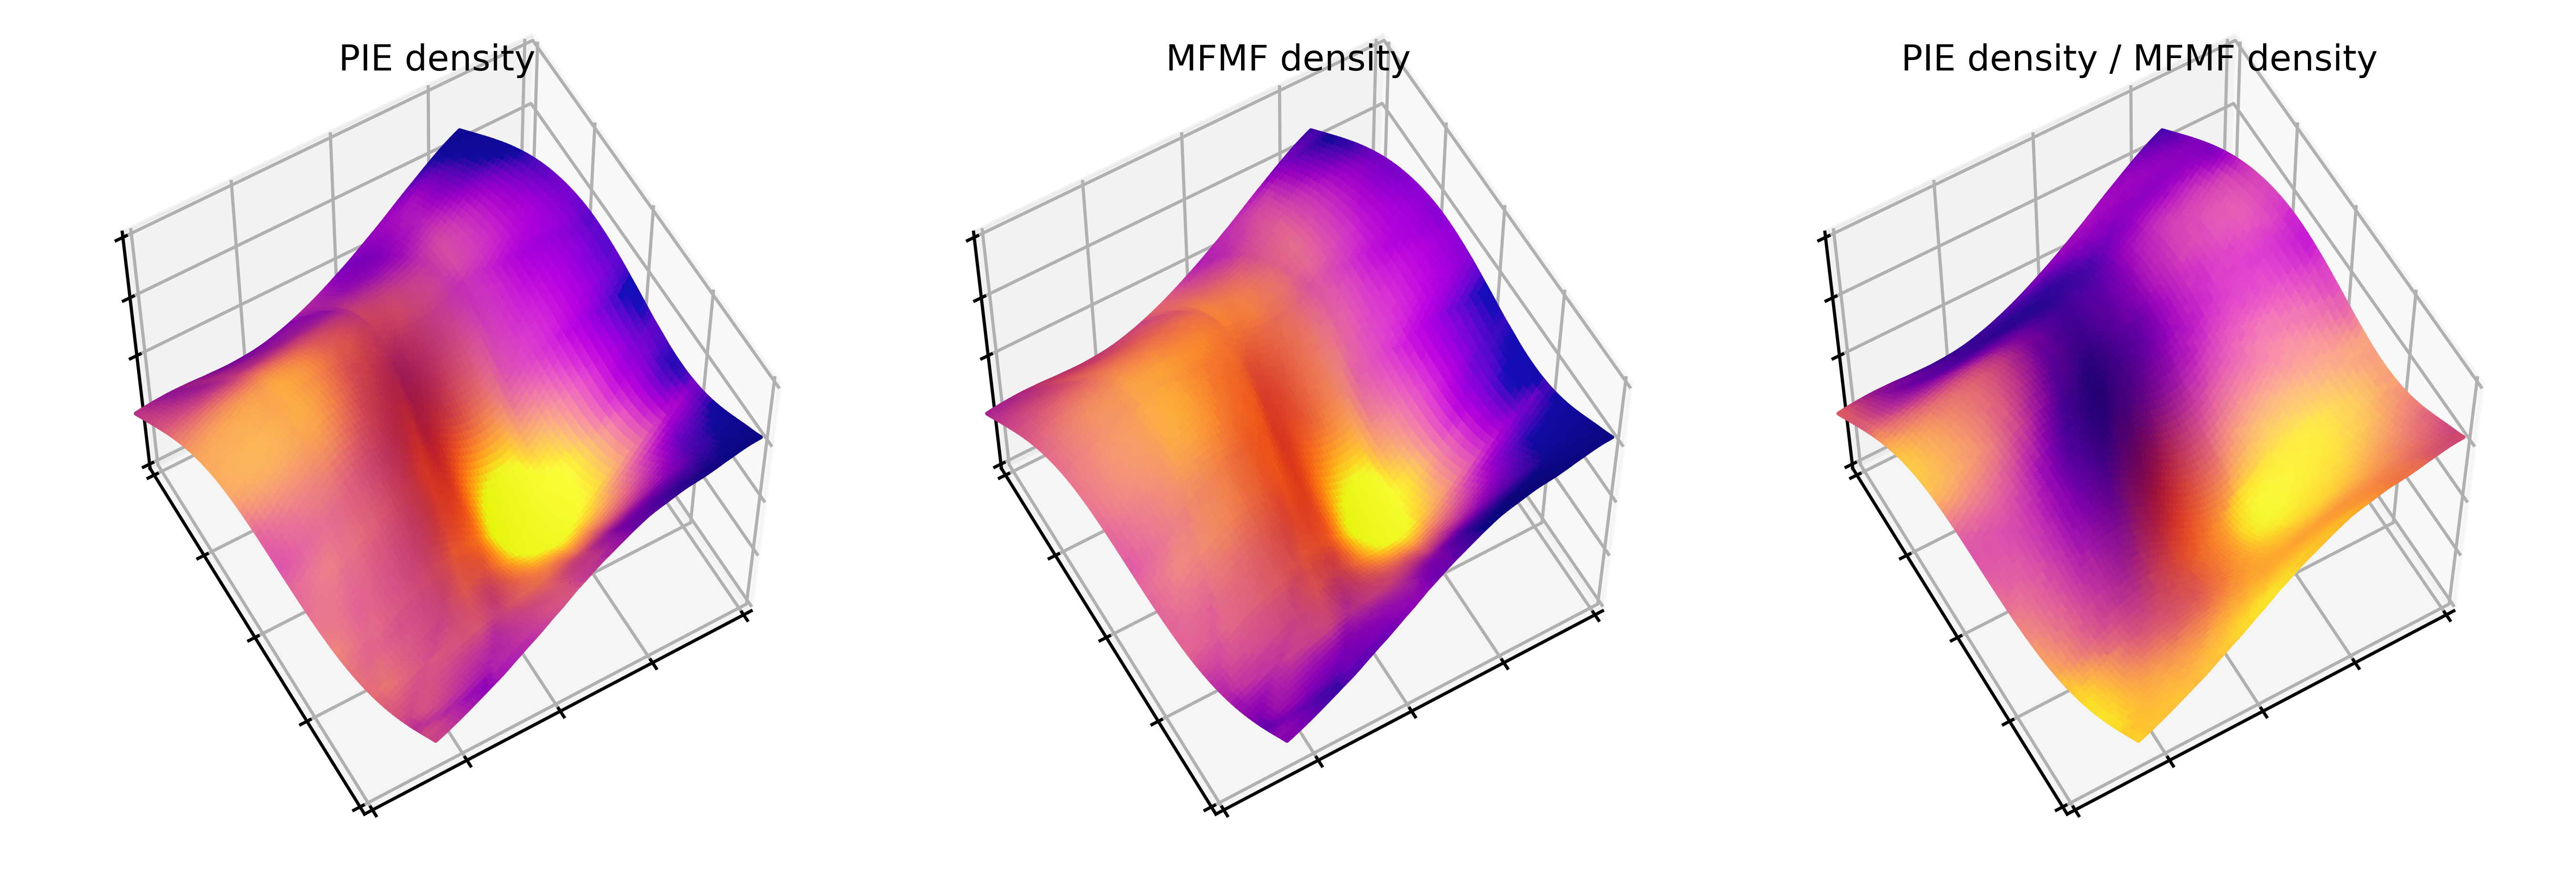

In [26]:
def cmap(vals):
    return ps.CMAP(np.clip((vals - cmin) / (cmax - cmin), 0., 1.))


fig, gs = ps.grid_width(3, 1, sep=0.03, lb_space=False)

for i, (x, logp, label) in enumerate(zip(xs, logps, labels)):
    ax = plt.subplot(gs[i], projection="3d")
    
    cmin, cmax = np.mean(logp) - 2*np.std(logp), np.mean(logp) + 2*np.std(logp)
    
    rgb = cmap(logp).reshape((res, res, 4))
    ls = LightSource(azdeg=90, altdeg=75)
    rgb_shaded = ls.shade_rgb(
        rgb[:,:,:3], elevation=x[:,2].reshape((res, res)), fraction=1.0, vert_exag=0.5, blend_mode="soft"
    )
    
    ax.plot_surface(
        x[:,0].reshape((res, res)),
        x[:,1].reshape((res, res)),
        x[:,2].reshape((res, res)),
        facecolors=rgb_shaded,
        rstride=1, cstride = 1,
        linewidth=1.,
        shade=False
    )

    ax.set_xlim3d(-boundary, boundary)
    ax.set_ylim3d(-boundary, boundary)
    ax.set_zlim3d(-boundary, boundary)

    ax.set_title(label, fontsize=9)
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_zlabel("z")
    # ax._axis3don = False
    ax.set_xticklabels([""]*3)
    ax.set_yticklabels([""]*3)
    ax.set_zticklabels([""]*3)
    
    ax.view_init(60, 60)

plt.savefig("../figures/mixture_manifold_pie_vs_mlf_density.pdf")
